# LSTM

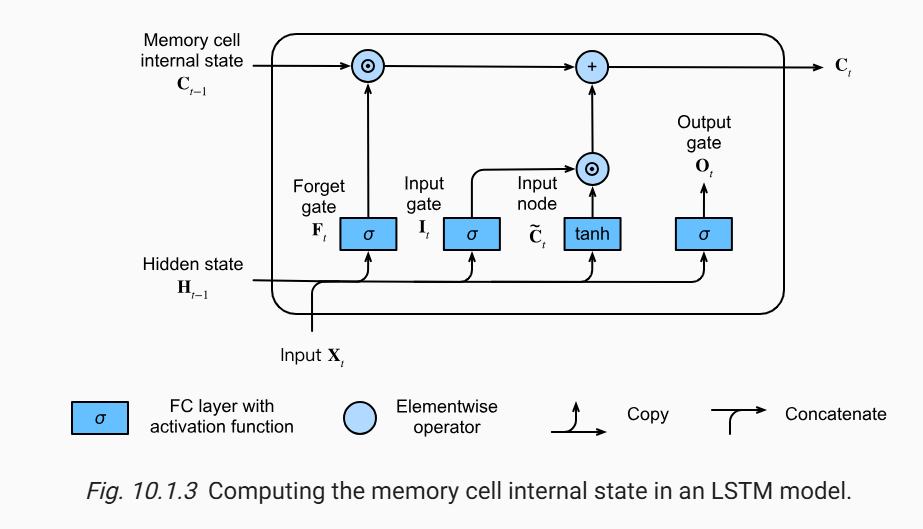

In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=f9430ac1aa344128e00644f51d3f712d8a55cfc4efc800fa9c3d79072e90244c
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
!git clone https://github.com/PacktPublishing/Python-Natural-Language-Processing-Cookbook.git

Cloning into 'Python-Natural-Language-Processing-Cookbook'...
remote: Enumerating objects: 308, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 308 (delta 36), reused 39 (delta 12), pack-reused 224 (from 1)
Receiving objects: 100% (308/308), 658.34 MiB | 20.55 MiB/s, done.
Resolving deltas: 100% (128/128), done.
Updating files: 100% (93/93), done.


In [ ]:
%cd Python-Natural-Language-Processing-Cookbook

/content/Python-Natural-Language-Processing-Cookbook


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
!git clone https://github.com/jchook/wordseg.git

Cloning into 'wordseg'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 43 (delta 2), reused 6 (delta 2), pack-reused 33 (from 1)
Receiving objects: 100% (43/43), 525.98 KiB | 1.63 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
%cd wordseg

/content/Python-Natural-Language-Processing-Cookbook/wordseg


In [ ]:
%cd wordseg

/content/Python-Natural-Language-Processing-Cookbook/wordseg/wordseg


In [ ]:
import re
import pandas as pd
from tqdm import tqdm
from core import segment # segment words
import html
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from langdetect import detect # detect language
from langdetect.lang_detect_exception import LangDetectException #processing exception in case error
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # add pad to sequences
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
%cd ..

/content/Python-Natural-Language-Processing-Cookbook


In [ ]:
from Chapter04.lstm_classification import plot_model, save_tokenizer, load_tokenizer

In [ ]:
MAX_NUM_WORDS = 50000
EMBEDDING_DIM = 500
twitter_csv = "/content/drive/MyDrive/Data/training.1600000.processed.noemoticon.csv"
english_twitter = "/content/drive/MyDrive/Data/twitter_english.csv"

tqdm.pandas()

def evaluate(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    y_pred = np.where(y_pred > 0.5, 1,0)
    y_pred = [pred[0] for pred in y_pred]
    print(classification_report(y_test, y_pred, labels=[0, 1], target_names=['negative', 'positive']))

def lang_detect(text):
    lang = ""
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "None"
    return lang

def segment_hashtags(tweet):
    matches = re.findall(r'#[a-z0-9]+', tweet)
    for match in matches:
        tweet = re.sub(match, " ".join(segment(match)[0]), tweet)
    return tweet


def filter_english(df, save_path):
    df['language'] = df['tweet'].progress_apply(lambda t: lang_detect(t))
    df = df[df['language'] == 'en']
    df.to_csv(save_path, encoding="latin1")
    return df

def clean_data(df):
    #Lowercase all tweets
    df['tweet'] = df['tweet'].progress_apply(lambda t: t.lower())
    #Decode HTML
    df['tweet'] = df['tweet'].progress_apply(lambda t: html.unescape(t))
    #Remove @ mentions
    df['tweet'] = df['tweet'].progress_apply(lambda t: re.sub(r'@[A-Za-z0-9]+','',t))
    #Remove URLs
    df['tweet'] = df['tweet'].progress_apply(lambda t: re.sub('https?://[A-Za-z0-9./]+','',t))
    #Segment hashtags
    df['tweet'] = df['tweet'].progress_apply(lambda t: segment_hashtags(t))
    #Remove remaining non-alpha characters
    df['tweet'] = df['tweet'].progress_apply(lambda t: re.sub("[^a-zA-Z]", " ", t))
    #Re-label positive tweets with 1 instead of 4
    df['sentiment'] = df['sentiment'].apply(lambda t: 1 if t==4 else t)
    return df

def get_data(filename, save_path, num_datapoints=80000):
    df = pd.read_csv(filename, encoding="latin1")
    df.columns = ['sentiment', 'id', 'date', 'query', 'username', 'tweet']
    df = pd.concat([df.head(num_datapoints),df.tail(num_datapoints)])
    df = filter_english(df, save_path)
    return df

In [ ]:
df = get_data(twitter_csv, "Chapter05/twitter_english.csv")
df.head()

100%|██████████| 160000/160000 [16:48<00:00, 158.60it/s]


,sentiment,id,date,query,username,tweet,language
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,en
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,en
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,en
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",en
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,en


In [ ]:
df = pd.read_csv(english_twitter, encoding="latin1")
print(df.head())

   Unnamed: 0  sentiment          id                          date     query  \
0           0          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
1           1          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
2           2          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
3           3          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4           4          0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY   

        username                                              tweet language  
0  scotthamilton  is upset that he can't update his Facebook by ...       en  
1       mattycus  @Kenichan I dived many times for the ball. Man...       en  
2        ElleCTF    my whole body feels itchy and like its on fire        en  
3         Karoli  @nationwideclass no, it's not behaving at all....       en  
4       joy_wolf                      @Kwesidei not the whole crew        en  


In [ ]:
df = clean_data(df)
df.head()

100%|██████████| 148635/148635 [00:01<00:00, 103447.54it/s]


,Unnamed: 0,sentiment,id,date,query,username,tweet,language
0,0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can t update his facebook by ...,en
1,1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to s...,en
2,2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,en
3,3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no it s not behaving at all i m mad why am...,en
4,4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,not the whole crew,en


In [ ]:
df['tweet']

,tweet
0,is upset that he can t update his facebook by ...
1,i dived many times for the ball managed to s...
2,my whole body feels itchy and like its on fire
3,no it s not behaving at all i m mad why am...
4,not the whole crew
...,...
148630,just woke up having no school is the best fee...
148631,thewdb com very cool to hear old walt interv...
148632,are you ready for your mojo makeover ask me f...
148633,happy th birthday to my boo of alll time ...


In [ ]:
def train_model(df):
    tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(df['tweet'].values)
    save_tokenizer(tokenizer, 'Chapter05/twitter_tokenizer.pkl')
    X = tokenizer.texts_to_sequences(df['tweet'].values)
    X = pad_sequences(X)
    Y = df['sentiment'].values
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.20, random_state=42, stratify=df['sentiment'])
    model = Sequential()
    optimizer = tf.keras.optimizers.Adam(0.00001)
    model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
    model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
    model.add(Dense(1, activation='sigmoid'))
    loss='binary_crossentropy' #Binary in this case
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    epochs = 15
    batch_size = 32
    es = [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3, callbacks=es)
    accr = model.evaluate(X_test,Y_test)
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
    model.save('Chapter05/twitter_model.h5')
    evaluate(model, X_test, Y_test)
    plot_model(history)

def main():
    #df = get_data(twitter_csv, "Chapter05/twitter_english.csv")
    df = pd.read_csv(english_twitter, encoding="latin1")
    df = clean_data(df)
    train_model(df)


if __name__ == "__main__":
    main()

100%|██████████| 148635/148635 [00:00<00:00, 155325.16it/s]


GPU(s) detected: ['/physical_device:GPU:0']


RuntimeError: Physical devices cannot be modified after being initialized